## Notebook for hyperparameter-tuning for TimeVAE

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
from models.data_generating_models.time_vae import TimeVAE
import wandb

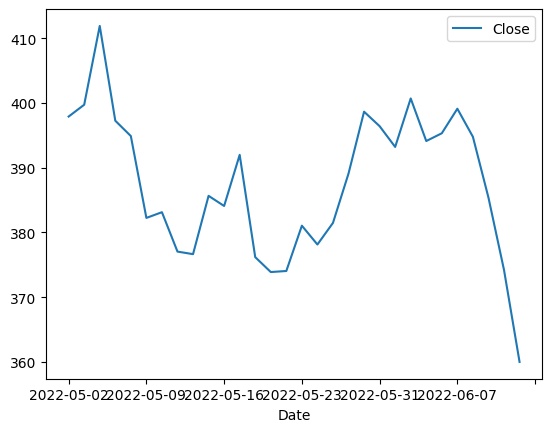

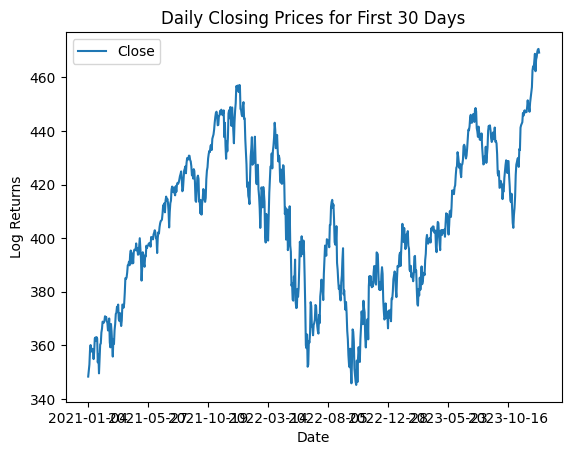

Log returns description: 
             Close
count  752.000000
mean     0.000396
std      0.011092
min     -0.044456
25%     -0.005606
50%      0.000459
75%      0.006998
max      0.053497


In [16]:
train_data = pd.read_csv("../data/raw/spy_daily_closing_prices.csv", index_col=0)

i = 334
train_data.iloc[i:i+30].plot(y='Close', use_index=True)
train_data.plot(y='Close', use_index=True)
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.title('Daily Closing Prices for First 30 Days')
plt.show()

train_data = np.log(train_data/train_data.shift(1)).dropna()
print("Log returns description: \n", train_data.describe())


N = 30
M = 1000
load_params = False

In [89]:
hyperparameters = {
    "sequence_length": 30,
    "latent_dim": 10,
    "hidden_layer_sizes": [32, 32],
    "reconstruction_wt": 3.0,
    "batch_size": 32,
    "use_residual_conn": True,
    "trend_poly": 2,
    "custom_seas": None
}
model = TimeVAE(train_data, N, M, load_params=False, config=hyperparameters)
model.fit_params_to_data()
print(f"Reconstruction loss: {model.params["model"].history.history["reconstruction_loss"][-1]}")
print(f"Loss: {model.params["model"].history.history["loss"][-1]}")

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - kl_loss: 9.6666 - loss: 5809.6387 - reconstruction_loss: 1933.3241 - learning_rate: 0.0010
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 139.5857 - loss: 897.3853 - reconstruction_loss: 252.5999 - learning_rate: 0.0010
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 199.9701 - loss: 427.8296 - reconstruction_loss: 75.9532 - learning_rate: 0.0010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 168.6640 - loss: 276.5951 - reconstruction_loss: 35.9770 - learning_rate: 0.0010
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 135.1695 - loss: 244.2007 - reconstruction_loss: 36.3437 - learning_rate: 0.0010
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 133.8636 - loss: 233.3489 - reconstruction_loss: 33.1618 - learning_rate: 0.0010
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 137.2712 - loss: 251.8225 - reconstruction_loss: 38.1838 - learning_rate: 0.0010
Epoc

In [90]:
model.generate_data()
# model.synth_data.to_csv("../data/processed/time_vae_synth_data.csv")
print(f"Max: {np.max(model.synth_data.max())}")
print(f"Min: {np.min(model.synth_data.min())}")
print(f"Std: {np.mean(model.synth_data.std(axis=1))}")

Max: 0.16087836027145386
Min: -0.06759253889322281
Std: 0.006252926774322987


(1000, 30)


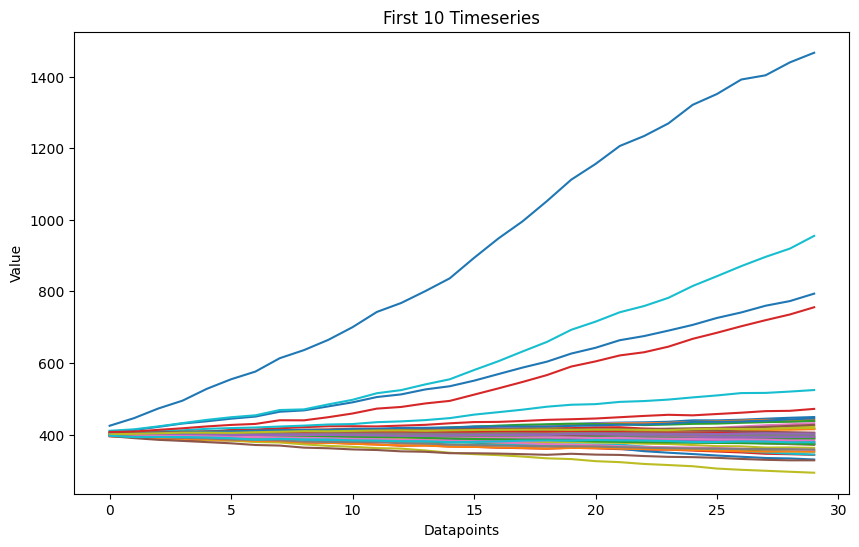

In [88]:
# model = "time_vae"

# df = pd.read_csv(f"../data/processed/{model}_synth_data.csv", index_col=0)
df = model.synth_data
df = 400 * np.exp(df.cumsum(axis=1))

print(df.shape)

# Plot the first 10 timeseries
plt.figure(figsize=(10, 6))
for i in range(50):
    plt.plot(df.iloc[i, :])
plt.xlabel('Datapoints')
plt.ylabel('Value')
plt.title('First 10 Timeseries')
plt.show()

# Create subplots for each of the first 10 timeseries
# fig, axs = plt.subplots(10, 1, figsize=(10, 20))
# for i in range(10):
#     axs[i].plot(df.iloc[i, :])
#     axs[i].set_title(f'Timeseries {i+1}')
#     axs[i].set_xlabel('Datapoints')
#     axs[i].set_ylabel('Value')
# plt.tight_layout()
# plt.show()

In [5]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sondre-rogde (sondre-rogde-ntnu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:

# Initialize wandb
wandb.init(project="timevae-hyperparameter-tuning")

# Define sweep configuration
sweep_config = {
    'method': 'random',  # or 'grid', 'bayes'
    'metric': {
        'name': 'loss',
        'goal': 'minimize'
    },
    'parameters': {
        'sequence_length': {
            'values': [5, 10, 15]
        },
        'latent_dim': {
            'values': [4, 8, 16]
        },
        'hidden_layer_sizes': {
            'values': [[8, 8], [8, 8, 8], [16, 16, 16]]
        },
        # 'reconstruction_wt': {
        #     'values': [1.0, 3.0, 5.0]
        # },
        'batch_size': {
            'values': [16, 32, 64]
        },
        # 'use_residual_conn': {
        #     'values': [True, False]
        # },
        'trend_poly': {
            'values': [0, 1, 2]
        },
        # 'custom_seas': {
        #     'values': [None, 'weekly', 'monthly']
        # }
    }
}

# Initialize sweep
sweep_id = wandb.sweep(sweep_config, project="timevae-hyperparameter-tuning")

# Define the training function
def train():
    # Initialize a new wandb run
    wandb.init()
    
    # Get hyperparameters from wandb
    config = wandb.config
    
    # Update hyperparameters
    hyperparameters.update({
        "sequence_length": config.sequence_length,
        "latent_dim": config.latent_dim,
        "hidden_layer_sizes": config.hidden_layer_sizes,
        "reconstruction_wt": config.reconstruction_wt,
        "batch_size": config.batch_size,
        "use_residual_conn": config.use_residual_conn,
        "trend_poly": config.trend_poly,
        "custom_seas": config.custom_seas
    })
    
    # Initialize the model
    model = TimeVAE(train_data, N, M, load_params=False, config=hyperparameters)
    
    # Train the model (assuming a train method is defined in TimeVAE)
    model.fit_params_to_data(train_data)
    
    # Log the loss (assuming a get_loss method is defined in TimeVAE)
    loss = model.params["model"].history.history["reconstruction_loss"][-1]
    wandb.log({"loss": loss})

# Run the sweep
wandb.agent(sweep_id, train, count=10)